# Simulation cycle time

This tutorial demonstrates the speed of the simulation cycle for retraining RS model. We evaluate the time of the main steps of the cycle, shown in rs_performance_evaluation.ipynb notebook, but with a larger size of data.  

Before running the simulation cycle, we need to
 - initialize the recommender model and fit it to the historical data,
 - construct the response function pipeline and fit it to the items.
 
We measure the time of the main steps of the simulation cycle:

- sampling visiting users, 
- generating responses to recommendations, 
- updating user history with received responses, 
- metric computation time.

We excluded the RS retraining stage from the measurement, since RS is not part of the simulator and did not include the RS model prediction time to the results. We did not show the time to obtain the history of interactions because the size of the logged data is the same before the cycle starts for each sample size.

For each sample of visiting users in the range of 1M to 50M, we measured the time for the first interaction of the simulation cycle. The time was averaged over 5 runs for each sample size.

We observe that the iteration time increases approximately twice, from 23 to 40 seconds, with the sample size increasing by 5 times, from 10 to 50 million users, with the most size-dependent operations being the response generation and the generated data saving. 

## Imports and preparations

In [1]:
import os
import sys
os.environ["JAVA_HOME"] = "/home/jovyan/ivanova/env39_sim4rec_demo_new"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["OMP_NUM_THREADS"] = "32"
os.environ["NUMBA_NUM_THREADS"] = "4"

In [2]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf

from experiments.response_models.utils import calc_metric
from sim4rec.modules import RealDataGenerator
from sim4rec.modules import Simulator
from sim4rec.recommenders.ucb import UCB
from sim4rec.response import BernoulliResponse,  ActionModelTransformer

warnings.filterwarnings("ignore") 

In [3]:
# path to spark tmp folder and simulator checkpoints
SPARK_LOCAL_DIR = './tmp/task_1'
CHECKPOINT_DIR = './tmp/task_1_checkpoints'

In [4]:
%%bash -s "$CHECKPOINT_DIR" "$SPARK_LOCAL_DIR"
# Simulator keeps history of interactions between users and recommender system
# To re-run the simulation cycle or start a new one, clear the directory or use a different CHECKPOINT_DIR
rm -rf $1 $2

In [4]:
NUM_JOBS = 16

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_JOBS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_JOBS * 3}')\
    .config('spark.default.parallelism', f'{NUM_JOBS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")\
    .config("spark.driver.memory", "64g")\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')

24/10/09 23:16:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/09 23:16:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/10/09 23:16:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/09 23:16:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/10/09 23:16:30 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/10/09 23:16:30 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [6]:
NUM_USERS = 50000000 # number of generated users
NUM_ITEMS = 10000 # number of generated items
K = 5 # number of predicted items
NUM_ITER = 1 # number of iterations
SEED = 1234
np.random.seed(SEED)

## Data generation

We create 50M users and 10K items, fit RealDataGenerator to them and then generate 50M users and 10K items. 

In [7]:
users = spark.createDataFrame([[x] for x in range(NUM_USERS)], schema=["user_idx"])
users.count()

50000000

In [8]:
items = spark.createDataFrame([[x] for x in range(NUM_ITEMS)], schema=["item_idx"])
items.count()

10000

In [9]:
item_generator = RealDataGenerator(label='items_real', seed=SEED, parallelization_level=NUM_JOBS * 3)
user_generator = RealDataGenerator(label='users_real', seed=SEED, parallelization_level=NUM_JOBS * 3)

item_generator.fit(items)
user_generator.fit(users)

item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)
item_generator.getDataSize()

10000

In [10]:
user_generator.sample(0.1).count()

5001100

# Before running the simulation cycle

## Recommender model

UCB model should be fitted to historical data before it can be refitted in cycle. Let's assume we had one interaction for simplicity.

In [11]:
# initialization of recommender model
rs_model = UCB(sample=False, seed=SEED)
# fit recommender model
rs_model.fit(
    log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1))
)

## Response Function

The response function in this tutorial is constant over time and very simple. The response is binary, response == 1 means the user bought the item.  

The probability of a response is fixed and is equal to one tenth of the last digit of an `item_idx`. So there are more popular items with higher probability of a response and a simple recommender model should be able to identify them.

The response function takes a dataframe with the columns `user_idx`, `item_idx`, `relevance` and returns a dataframe with the columns `user_idx`, `item_idx`, `relevance`, `response_proba`, `response`, adding the response column to the original columns. If the initial dataframe had other columns, they are returned as well.

In [12]:
class PopBasedTransformer(ActionModelTransformer):
    def __init__(
        self,
        inputCol: str = None,
        outputCol: str = None,
    ):
        """
        Class for the response function. 
        The probability of a response is fixed and 
        is equal to one tenth of the last digit of an item id from inputCol. 
        The probability of response is one tenth of the last digit of an item_idx.
        :param inputCol: Name of the item_id column
        :param outputCol: Name of the response probability column
        :returns: dataframe with outputCol
        """
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataframe):
        return dataframe.withColumn(
            self.outputCol, (sf.col(self.inputCol) % sf.lit(10)) / sf.lit(10)
        )

To construct the response function pipeline, we need to initialize PopBasedTransformer to get the response probability for each item and BernoulliResponse to model the non-deterministic behavior of the user.

In [13]:
# initialization of response function
popularity_model = PopBasedTransformer(inputCol="item_idx", outputCol="response_proba")
# initialization of Bernoulli response sampling
br = BernoulliResponse(inputCol="response_proba", outputCol="response", seed=SEED)
# get response pipeline
response_pipeline = Pipeline(stages=[popularity_model, br])
# fit response pipeline
response_model = response_pipeline.fit(items)

# Training the model in the simulator

In [14]:
%%bash -s "$CHECKPOINT_DIR"
rm -rf $1

## Simulation cycle

For each sample of visiting users in the range of 1M to 50M, we initialize the simulator and start the simulation cycle. We collected the time for the first interaction of the simulation cycle for the following steps:

- sampling of visiting users, 
- generating responses to recommendations, 
- updating the user history with the received responses, 
- metric computation time.

We also collected additional information, such as total iteration time and sample size.

We did not show the time of obtaining the history of interactions because the size of the logged data is the same before the cycle starts for each sample size. We also did not show the RS model prediction time because RS is not part of the simulator.

In [15]:
users_shares = np.linspace(1000000, 50000000, 21) / NUM_USERS

time_list = []
for users_share in users_shares: 
    # Simulator initialization
    user_generator.initSeedSequence(SEED)
    item_generator.initSeedSequence(SEED)

    sim = Simulator(
        user_gen=user_generator,
        item_gen=item_generator,
        data_dir=f'{CHECKPOINT_DIR}/users_share_{users_share}',
        user_key_col='user_idx',
        item_key_col='item_idx',
        spark_session=spark
    )
    metrics = []
    for i in range(NUM_ITER):
        cycle_time = {}
        iter_start = time.time()
        
        # sample users
        start = time.time()
        current_users = sim.sample_users(users_share).cache()
        users_num = current_users.count()
        cycle_time['sample_users_time'] = time.time() - start

        # history of interactions
        log = sim.get_log(current_users)
        if log is not None:
            log = log.cache()
        else:
            log = users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)).cache()
        log.count()

        # getting recommendations for sampled users from the recommender system
        recs = rs_model.predict(
            log=log, k=5, users=current_users, items=items, filter_seen_items=False
        ).cache()
        recs.count()

        # getting responses to recommended items from the response function
        start = time.time()
        true_resp = sim.sample_responses(
            recs_df=recs,
            user_features=None,
            item_features=None,
            action_models=response_model,
        ).cache()
        true_resp.count()
        cycle_time['sample_responses_time'] = time.time() - start

        # update user interaction history
        start = time.time()
        sim.update_log(true_resp, iteration=i)
        cycle_time['update_log_time'] = time.time() - start

        # measure the quality of the recommender system
        start = time.time()
        metrics.append(calc_metric(true_resp))
        cycle_time['metrics_time'] = time.time() - start

        current_users.unpersist()
        if log is not None:
            log.unpersist()
        recs.unpersist()
        true_resp.unpersist()

        cycle_time['iter_time'] = time.time() - iter_start
        cycle_time['users_num'] = users_num

        time_list.append(cycle_time)
        print(f'Iteration {i} ended in {cycle_time["iter_time"]} seconds')
        pd.DataFrame(time_list).to_csv('cycle_time_50M_users.csv', index=False)

Iteration 0 ended in 26.025669813156128 seconds


Iteration 0 ended in 20.607492923736572 seconds


Iteration 0 ended in 25.37016487121582 seconds


Iteration 0 ended in 23.709872245788574 seconds


Iteration 0 ended in 23.787129878997803 seconds


Iteration 0 ended in 28.174647331237793 seconds


Iteration 0 ended in 34.7930908203125 seconds


Iteration 0 ended in 34.87754034996033 seconds


Iteration 0 ended in 37.753700494766235 seconds


Iteration 0 ended in 34.05193638801575 seconds


Iteration 0 ended in 35.776469469070435 seconds


Iteration 0 ended in 41.16743874549866 seconds


Iteration 0 ended in 41.907142877578735 seconds


Iteration 0 ended in 42.37422752380371 seconds


Iteration 0 ended in 38.64884424209595 seconds


Iteration 0 ended in 45.65352129936218 seconds


Iteration 0 ended in 42.494946002960205 seconds


Iteration 0 ended in 46.69434404373169 seconds


Iteration 0 ended in 48.16459345817566 seconds


Iteration 0 ended in 51.17348074913025 seconds


Iteration 0 ended in 50.241539001464844 seconds


In [22]:
cycle_time_df = pd.read_csv('cycle_time_50M_users_5seeds.csv')

In [29]:
cycle_time_df = cycle_time_df.groupby(['index']).mean()
cycle_time_df['simulator_time'] = cycle_time_df.iloc[:, :-2].sum(axis=1)

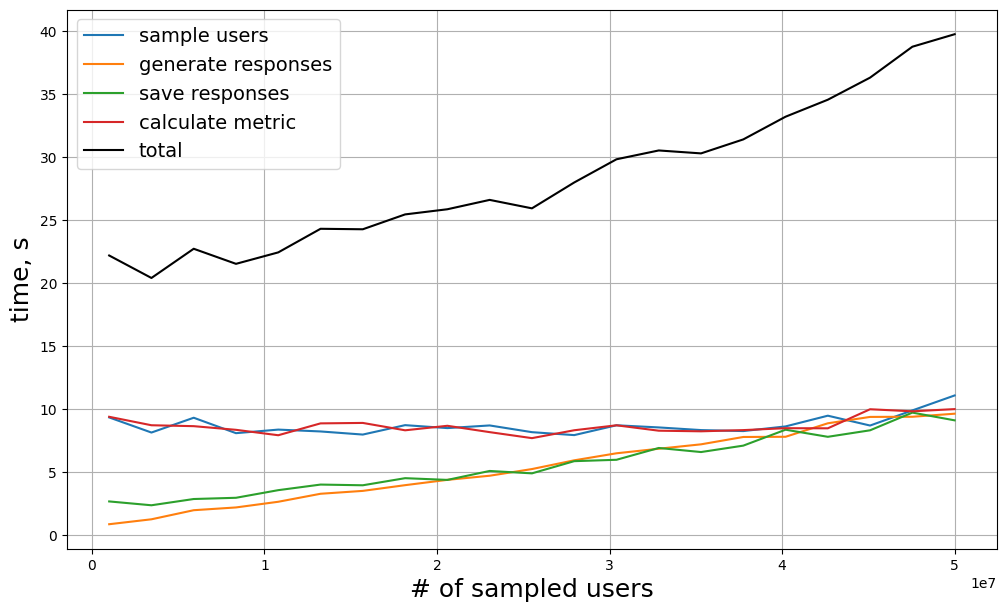

In [30]:
plt.figure(figsize=(12, 7))
sns.lineplot(cycle_time_df, x='users_num', y='sample_users_time', label='sample users');
sns.lineplot(cycle_time_df, x='users_num', y='sample_responses_time', label='generate responses');
sns.lineplot(cycle_time_df, x='users_num', y='update_log_time', label='save responses');
sns.lineplot(cycle_time_df, x='users_num', y='metrics_time', label='calculate metric');
sns.lineplot(cycle_time_df, x='users_num', y='simulator_time', label='total', color='black');
plt.legend(loc='upper left', fontsize=14);
plt.grid()
plt.xlabel("# of sampled users", fontsize=18)
plt.ylabel("time, s", fontsize=18);

The most size-dependent operations are the response generation and the generated data saving. 